# DSRP - Despliegue de modelos de Machine Learning

In [110]:
# %pip install xgboost scikit-learn pandas matplotlib seaborn python-dotenv mlflow loguru

In [211]:
# Preprocesamiento
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = 12,8
sns.set_style("whitegrid")

# utilidades
import mlflow
import dotenv
from loguru import logger

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Modelos 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [160]:
train_data = pd.read_csv("data/loan-default-prediction/train_v2.csv")
train_data

/var/folders/48/sxctwb191tg5r634mnnb0p8m0000gn/T/ipykernel_98326/3859236496.py:1: DtypeWarning: Columns (135,204,274,417) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("data/loan-default-prediction/train_v2.csv")


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,...,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,...,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,...,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,...,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,...,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105466,105467,126,8,0.006620,2200,4,76831,331.0,2366.0,125.25,...,3,1.07,-0.92,0.82,0.3809,-0.5489,0,0,93,0
105467,105468,137,9,0.358568,2200,4,9836,3898.0,1106.0,135.88,...,3,0.33,-0.18,0.10,0.2357,-0.8627,1,0,93,0
105468,105469,129,9,0.241858,2200,4,627,7081.0,6577.0,128.44,...,4,1.18,-0.70,0.44,0.1649,1.0901,1,0,93,0
105469,105470,129,9,0.569719,2200,4,14629,4984.0,2101.0,127.25,...,2,0.01,0.00,0.00,0.0583,1.3355,1,0,93,0


# Pre-procesamiento

In [170]:
ID_VAR = "id"
TARGET_VAR = "loss"

# Basic cleaning - NOT RECOMMENDED
train_data.replace("NA", 0, inplace=True)
#train_data.fillna(train_data.mean(), inplace=True)

X = train_data.drop([ID_VAR, TARGET_VAR], axis=1)
y = train_data[TARGET_VAR]

X_train, X_test,y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=0)


PCA_COMPONENTS = 20

base_pipeline = Pipeline(steps=[
    ("imputation", SimpleImputer(
        missing_values=np.nan, strategy='mean'
    )),
    ("scaling", StandardScaler()),
    ("dim_reduction", PCA(n_components=PCA_COMPONENTS))
])
base_pipeline.fit(X_train)

Pipeline(steps=[('imputation', SimpleImputer()), ('scaling', StandardScaler()),
                ('dim_reduction', PCA(n_components=20))])

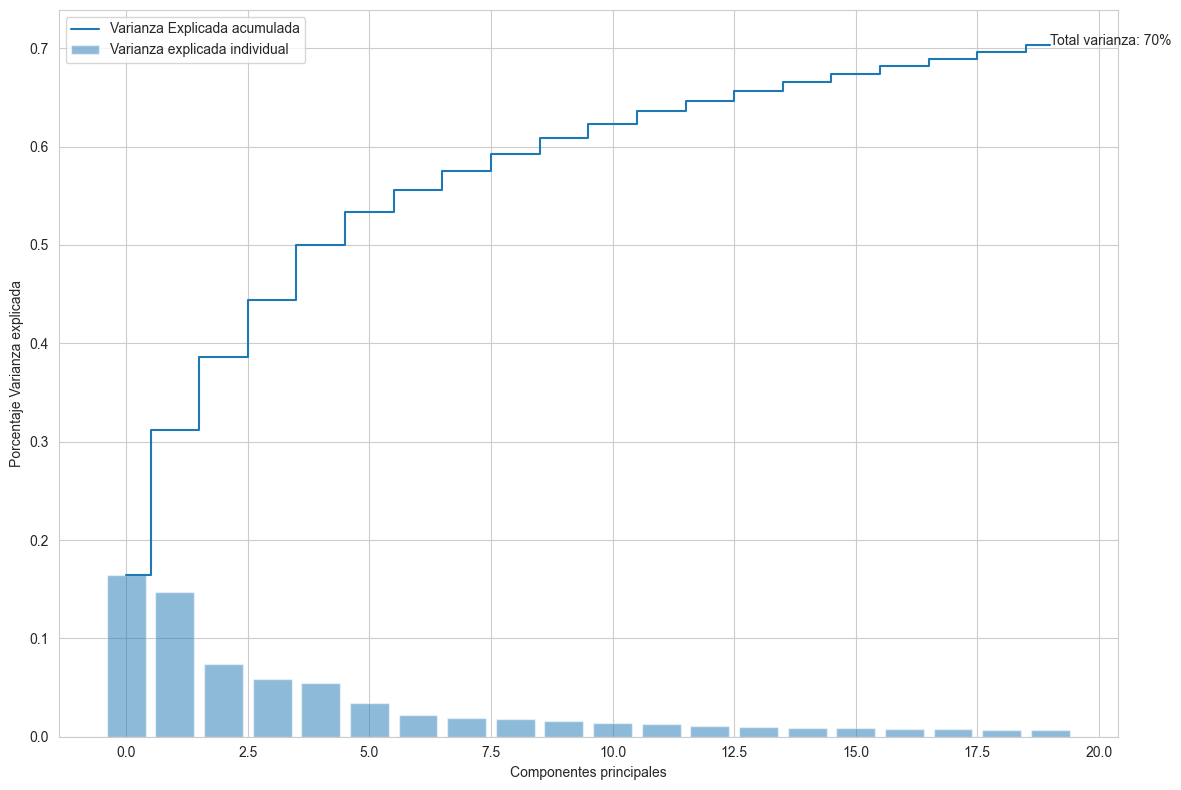

In [171]:
exp_var_pca = base_pipeline.steps[2][1].explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Varianza explicada individual')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Varianza Explicada acumulada')
plt.ylabel('Porcentaje Varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.annotate(f"Total varianza: {round(cum_sum_eigenvalues[-1]*100)}%", xy=( PCA_COMPONENTS-1, cum_sum_eigenvalues[-1],))
plt.tight_layout()
plt.show()

# Mlflow config

In [207]:
config = dotenv.dotenv_values(".env")

mlflow.set_registry_uri(uri=config.get("MLFLOW_TRACKING_URI"))
mlflow.create_experiment("DSRP Curso Despliegue de modelos de Machine Learning")
mlflow.sklearn.autolog()

# Entrenamiento - BASELINE

In [210]:
with mlflow.start_run(run_name="Modelo dummy - baseline"):
    
    dummy_pipeline = Pipeline(
        steps=base_pipeline.steps +
        [("model", DummyRegressor())]
    )
    dummy_pipeline.fit(X_train, y_train)
    dummy_predictions = dummy_pipeline.predict(X_test)
    mlflow.log_metrics(
        {
            "r2": r2_score( y_test, dummy_predictions),
            "mae": mean_absolute_error( y_test, dummy_predictions),
            "rmse": root_mean_squared_error( y_test, dummy_predictions)
        }
    ) 

2024/03/27 14:35:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/miguelarquezabdala/.pyenv/versions/3.11.5/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/27 14:35:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/miguelarqueza

In [190]:
y_train.mean()

0.8046008343604817

# Modelo 2: Red Elastica

In [212]:
with mlflow.start_run(run_name="Red Elastica"):

    elasticnet_pipeline = Pipeline(
        steps=base_pipeline.steps + [("model", ElasticNet(alpha=0.1, l1_ratio=0.4))]
    )
    elasticnet_pipeline.fit(X_train, y_train)
    elasticnet_predictions = elasticnet_pipeline.predict(X_test)
    
    mlflow.log_metrics(
        {
            "r2": r2_score(elasticnet_predictions, y_test),
            "mae": mean_absolute_error(elasticnet_predictions, y_test),
            "rmse": root_mean_squared_error(elasticnet_predictions, y_test)
        }
    )

2024/03/27 14:40:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/miguelarquezabdala/.pyenv/versions/3.11.5/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/27 14:41:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/miguelarqueza

# Modelo 3: XGboost

In [213]:
with mlflow.start_run(run_name="XGboost"):

    xgb_pipeline = Pipeline(
        steps=base_pipeline.steps + [("model", XGBRegressor())]
    )
    xgb_pipeline.fit(X_train, y_train)
    xgb_predictions = xgb_pipeline.predict(X_test)
    mlflow.log_metrics(
        {
            "r2": r2_score(xgb_predictions, y_test),
            "mae": mean_absolute_error(xgb_predictions, y_test),
            "rmse": root_mean_squared_error(xgb_predictions, y_test)
        }
    )

2024/03/27 14:42:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/miguelarquezabdala/.pyenv/versions/3.11.5/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/27 14:43:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/miguelarqueza